# Arabic Hand Written Characters Recognition
 
### Table Of Content 
1. **Imports**
2. **Reading Data**
3. **Show some samples**
4. **Data Generators**
5. **Model from scratch**
6. **Transfer Learning with vgg16**
7. **Training**
8. **Evaluation**

## Imports

In [1]:
import numpy as np  
import pandas as pd
import os
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Reading Data

In [3]:
!unzip "/content/Arabic Handwritten Characters Data.zip"

Streaming output truncated to the last 5000 lines.
 extracting: train/08440.png         
 extracting: train/08441.png         
 extracting: train/08442.png         
 extracting: train/08443.png         
 extracting: train/08444.png         
 extracting: train/08445.png         
 extracting: train/08446.png         
 extracting: train/08447.png         
 extracting: train/08448.png         
 extracting: train/08449.png         
 extracting: train/08450.png         
 extracting: train/08451.png         
 extracting: train/08452.png         
  inflating: train/08453.png         
 extracting: train/08454.png         
 extracting: train/08455.png         
 extracting: train/08456.png         
 extracting: train/08457.png         
  inflating: train/08458.png         
 extracting: train/08459.png         
  inflating: train/08460.png         
 extracting: train/08461.png         
 extracting: train/08462.png         
 extracting: train/08463.png         
 extracting: train/08464.png         

In [4]:
## paths to data
csv_path = '/content/train.csv'
images_path = '/content/train'

In [5]:
## function to add img paths to the dataframe
def dataframe(csv_path, images_path) :
    df = pd.read_csv(csv_path)
    filenames = os.listdir(images_path)
    file_id = []
    paths = []
    for img in filenames :
        idx = int(img.split('.')[0])
        file_id.append(idx)
        paths.append(os.path.join(images_path, img))
    images_df = pd.DataFrame({'id' : file_id, 'img_path' : paths})
    df = pd.merge(left = df, right = images_df, on = 'id')
    return df

In [6]:
df = dataframe(csv_path,images_path)
df.head()

,id,label,img_path
0,0,24,/content/train/00000.png
1,1,2,/content/train/00001.png
2,2,17,/content/train/00002.png
3,3,14,/content/train/00003.png
4,4,19,/content/train/00004.png


In [7]:
class ImagesDataset(Dataset):
    def __init__(self, df, transforms = None, mode = 'train'):
        
        self.df = df
        self.mode = mode
        self.transforms = transforms
        
        self.train, self.test_df = train_test_split(self.df, test_size = 0.2, 
                                                    shuffle = True, stratify = self.df['label'])
        
        self.train, self.test_df = self.train.reset_index(drop = True), self.test_df.reset_index(drop = True)
        
        self.train_df, self.valid_df = train_test_split(self.train, test_size = 0.2)
 
        self.train_df, self.valid_df = self.train_df.reset_index(drop = True), self.valid_df.reset_index(drop = True) 
        
        self.image_info = self.data_dict()   
    
    
    def data_dict(self) :
        image_info = defaultdict(dict)
        if self.mode == 'train' :
            data = self.train_df
        elif self.mode == 'validation' :
            data = self.valid_df
        elif self.mode == 'test' :
            data = self.test_df
        else :
            print('Invalid mode')
            
        for index, row in data.iterrows() :
            image_info[index] = {'img_path' : row['img_path'], 'label' : row['label']}
            
        return image_info    
        
    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        
            
        img_path = self.image_info[idx]['img_path']
        label = self.image_info[idx]['label']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
         
        if self.transforms : 
            image = self.transforms(image)
        
        sample = {'image' : image, 'label' : label}
        
        return sample

## show some samples

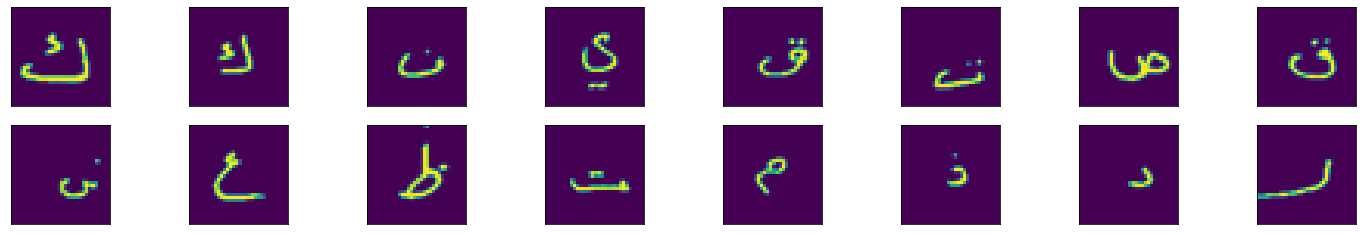

In [8]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(16):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    img_path = df.sample(1)['img_path'].values[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)

# Data Generators

In [9]:
def data_loader(df, batch_size = 32, num_workers = 0) :
    train_transforms = transforms.Compose([#transforms.ToPILImage(),
                                           #transforms.RandomRotation(20),
                                           #transforms.RandomAffine(0, translate=(0.4, 0.5)),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5), (0.5))])


    test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))])
    
    
    train_image_data = ImagesDataset(df, mode = 'train', transforms = train_transforms)
    valid_image_data = ImagesDataset(df, mode = 'validation', transforms = test_transforms)
    test_image_data = ImagesDataset(df, mode = 'test', transforms = test_transforms)
    
    train_loader = torch.utils.data.DataLoader(train_image_data, batch_size = batch_size, shuffle=True,
                                              num_workers = num_workers)
    validation_loader = torch.utils.data.DataLoader(valid_image_data, batch_size = batch_size,
                                                 shuffle=True, num_workers = num_workers)
    test_loader = torch.utils.data.DataLoader(test_image_data, batch_size = batch_size, 
                                         num_workers = num_workers)
    
    return train_loader, validation_loader,test_loader

In [10]:
train_loader, validation_loader,test_loader = data_loader(df)

## Model From Scratch

In [11]:
class classifier(nn.Module) :
    def __init__(self) :
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 5, padding = 2)  
        self.conv2 = nn.Conv2d(32, 32, 5, padding = 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding = 1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv6 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv7 = nn.Conv2d(256, 512, 3, padding = 1)
        
        # batch normalization
        self.b_norm_1 = nn.BatchNorm2d(64)
        self.b_norm_2 = nn.BatchNorm2d(256)
        self.b_norm_3 = nn.BatchNorm2d(512)
        
        # max polling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully connected layers
        self.fc1 = nn.Linear(2 * 2 * 512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 29)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x) :
        x = F.leaky_relu(self.conv1(x), 0.02)
        x = F.leaky_relu(self.conv2(x), 0.02)
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x), 0.02)
        x = self.pool(x)
        x = self.b_norm_1(x)
        
        x = F.leaky_relu(self.conv4(x), 0.02)
        x = F.leaky_relu(self.conv5(x), 0.02)
        x = F.leaky_relu(self.conv6(x), 0.02)
        x = self.pool(x)
        x = self.b_norm_2(x)
        
        x = F.leaky_relu(self.conv7(x), 0.02)
        x = self.pool(x)
        x = self.b_norm_3(x)
        

        
        # flatten the image
        x = x.view(x.shape[0], -1)
        
        x = F.leaky_relu(self.fc1(x), 0.02)
        x = F.leaky_relu(self.fc2(x), 0.02)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
model = classifier()
model

classifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b_norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b_norm_3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Line

## Training

In [12]:
def train(model, train_loader, validation_loader, model_save_path, device, epochs = 20 ) :
    # optimizer and loss critertion
    optimizer = optim.SGD(model.parameters(), lr = 0.01)
    criterion = nn.CrossEntropyLoss()

    model.to(device)
    
    training_losses = []
    validation_losses = []
    valid_loss_min = np.inf

    for e in range(epochs) :
        running_loss = 0
        validation_loss = 0

        ## training 
        model.train()
        for samples in train_loader :
            images = samples['image']
            labels = samples['label']
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*images.size(0) 
        
        ## evaluation
        model.eval()
        for samples in validation_loader :
            images = samples['image']
            labels = samples['label']

            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            validation_loss += loss.item()*images.size(0)

        train_loss = running_loss/len(train_loader.dataset)
        valid_loss = validation_loss/len(validation_loader.dataset)

        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        print('Epoch {} /tTraining Loss : {:0.6f} /tValidation Loss : {:0.6f}'.
              format(e+1, train_loss, valid_loss))    


        if valid_loss < valid_loss_min :
            print('Validation Loss Decreased ({:0.6f} --> {:0.6f}).   saving model...'.format(
                  valid_loss_min, valid_loss, torch.save(model.state_dict(), model_save_path)))

            valid_loss_min = valid_loss
            
    return training_losses, validation_losses


In [13]:
model_path = '/content/model.pth'
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

training_losses, validation_losses = train(model, train_loader, validation_loader,
                                           model_save_path = model_path, device = device, epochs = epochs)

Epoch 1 /tTraining Loss : 2.372377 /tValidation Loss : 2.338373
Validation Loss Decreased (inf --> 2.338373).   saving model...
Epoch 2 /tTraining Loss : 0.929955 /tValidation Loss : 1.877632
Validation Loss Decreased (2.338373 --> 1.877632).   saving model...
Epoch 3 /tTraining Loss : 0.488327 /tValidation Loss : 1.453286
Validation Loss Decreased (1.877632 --> 1.453286).   saving model...
Epoch 4 /tTraining Loss : 0.315868 /tValidation Loss : 0.572549
Validation Loss Decreased (1.453286 --> 0.572549).   saving model...
Epoch 5 /tTraining Loss : 0.230893 /tValidation Loss : 0.622298
Epoch 6 /tTraining Loss : 0.167326 /tValidation Loss : 0.438219
Validation Loss Decreased (0.572549 --> 0.438219).   saving model...
Epoch 7 /tTraining Loss : 0.125162 /tValidation Loss : 0.491066
Epoch 8 /tTraining Loss : 0.091402 /tValidation Loss : 0.133470
Validation Loss Decreased (0.438219 --> 0.133470).   saving model...
Epoch 9 /tTraining Loss : 0.071578 /tValidation Loss : 0.362739
Epoch 10 /tTrai

## Model Evaluation

In [14]:
def evaluate(test_loader, model, model_path, device = device) :
    
    train_on_gpu = torch.cuda.is_available()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    val_predict = []
    val_labels = []
    
    with torch.no_grad() :
        for samples in test_loader :
            images = samples['image']
            labels = samples['label']
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            ps = torch.exp(logits)
            top_ps, top_classes = ps.topk(1, dim = 1)
            labels = np.squeeze(labels.numpy()) if not train_on_gpu else np.squeeze(labels.cpu().numpy())
            val_labels.extend(labels)
            top_classes = np.squeeze(top_classes.numpy()) if not train_on_gpu else np.squeeze(top_classes.cpu().numpy())
            val_predict.extend(top_classes)
            
    return val_predict, val_labels

In [15]:
test_predict, test_labels = evaluate(test_loader, model = model, model_path = model_path)
accuracy_score(test_predict, test_labels)

0.9869791666666666

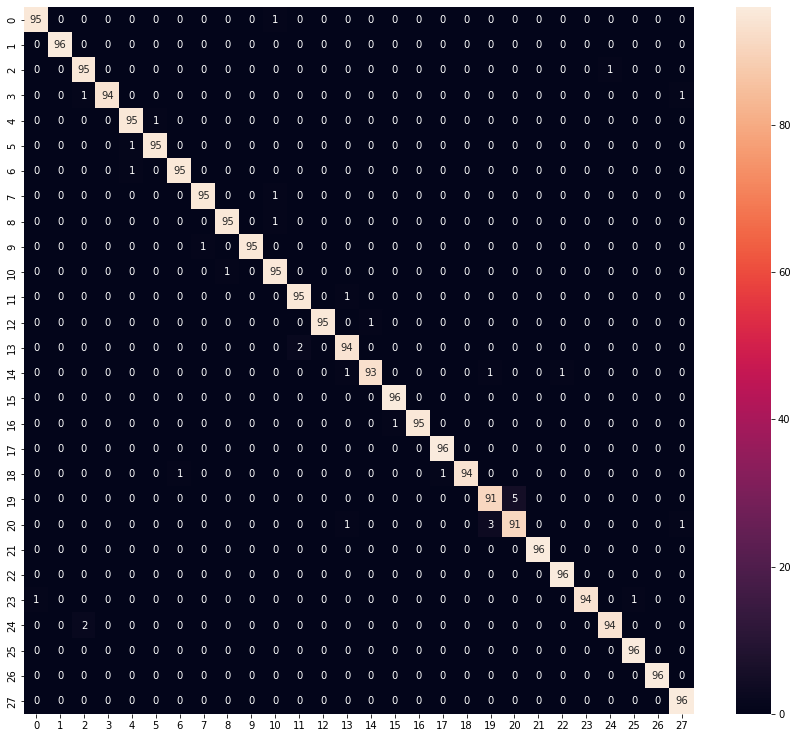

In [16]:
cm = confusion_matrix(test_labels, test_predict)
plt.figure(figsize=(15,13))
sns.heatmap(cm, annot=True)

## Make Prediction For One Image

In [45]:
def predict(img) :
  model.load_state_dict(torch.load(model_path))
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  img = torch.from_numpy(img).unsqueeze(0).type(torch.FloatTensor).to(device)
  prediction = model(img.unsqueeze(0))
  
  return torch.argmax(prediction)


## try prediction of image

img_path = df.sample(1)['img_path'].values[0]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image)

i = predict(image)
i

tensor(13, device='cuda:0')